In [4]:
!pip install fbprophet holidays
!pip install pandas numpy matplotlib seaborn datetime scikit-learn

     |████████████████████████████████| 61kB 2.8MB/s 
     |████████████████████████████████| 235kB 13.4MB/s 


In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import seaborn as sns
import holidays
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from sklearn.metrics import r2_score
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()

In [7]:
data_df = pd.read_csv('ARIMA_Full_Data.csv')
data_df.order_date = pd.to_datetime(data_df.order_date)
data_df.index = data_df.order_date
data_df.head()

,order_date,new_customers,number_of_orders,total_delivery_charged,delivery_discount,total_revenue,reported_transactions,reported_revenue_local,cost_local,net_revenue,gross_total_revenue
order_date,,,,,,,,,,,
2016-02-10,2016-02-10,1.0,5,25.0,0.0,391.72,0.0,0.0,0.0,0.0,391.72
2016-02-11,2016-02-11,1.0,2,18.0,0.0,169.24,0.0,0.0,0.0,0.0,169.24
2016-02-12,2016-02-12,0.0,1,9.0,0.0,58.88,0.0,0.0,0.0,0.0,58.88
2016-02-13,2016-02-13,1.0,1,9.0,0.0,99.80,0.0,0.0,0.0,0.0,99.80
2016-02-15,2016-02-15,0.0,4,24.0,0.0,710.35,0.0,0.0,0.0,0.0,710.35


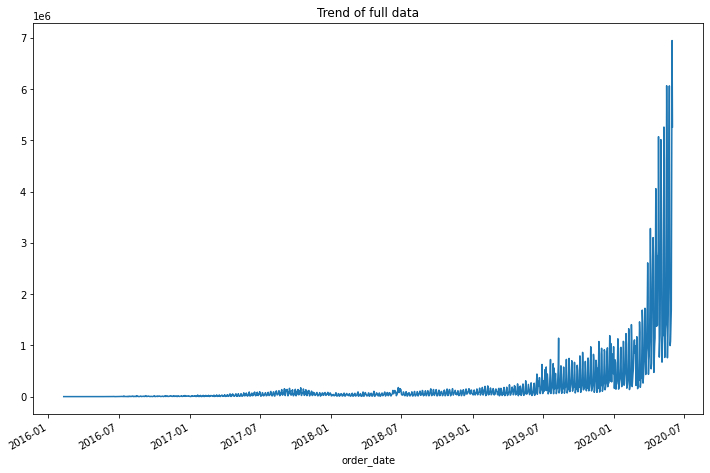

In [8]:
ax = plt.figure(figsize=(12,8))
data_df['gross_total_revenue'].plot()
plt.title('Trend of full data')
plt.show()

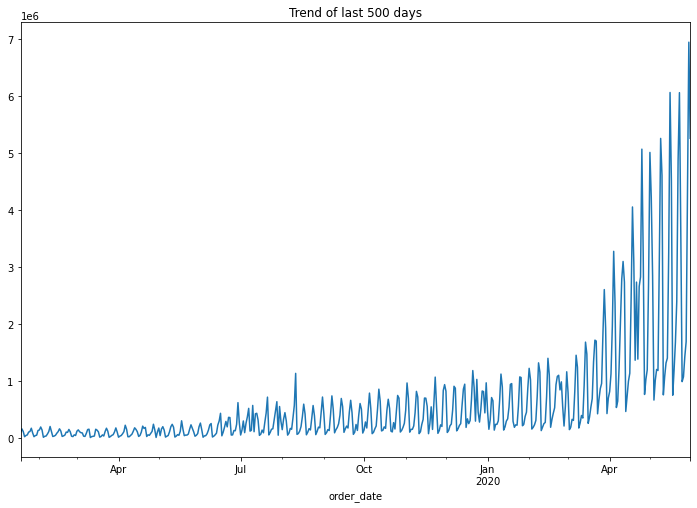

In [9]:
ax = plt.figure(figsize=(12,8))
data_df['gross_total_revenue'].iloc[-500:].plot()
plt.title('Trend of last 500 days')
plt.show()

In [44]:
train_data = pd.DataFrame(columns=['ds', 'y'])
train_data['ds'] = pd.to_datetime(data_df.index[-500:-30])
train_data['y'] = data_df['gross_total_revenue'].iloc[-500:-30].values

test_data = pd.DataFrame(columns=['ds', 'y'])
test_data['ds'] = pd.to_datetime(data_df.index[-30:])
test_data['y'] = data_df['gross_total_revenue'].iloc[-30:].values

print(train_data.shape[0])
print(test_data.shape[0])

470
30


In [45]:
model1 = Prophet(interval_width=0.95)
model1.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
pred_dates = model1.make_future_dataframe(periods=30)
forecast = model1.predict(pred_dates)

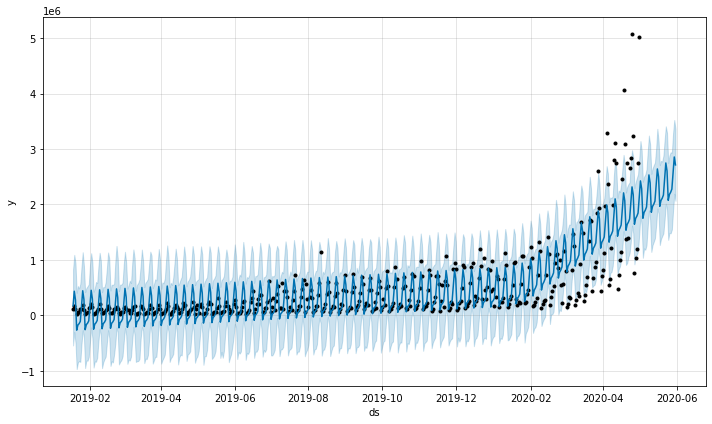

In [48]:
fig = model1.plot(forecast)

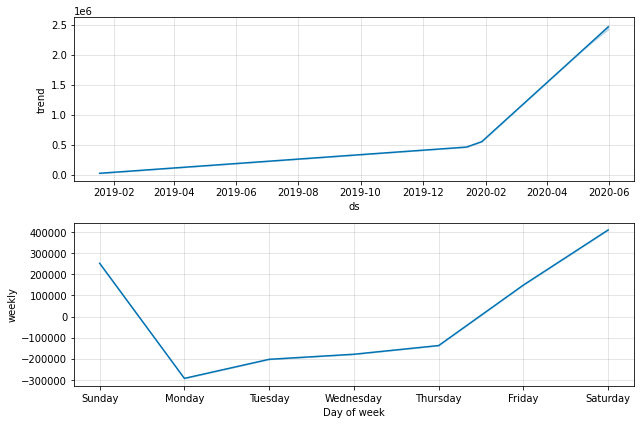

In [50]:
fig = model1.plot_components(forecast)

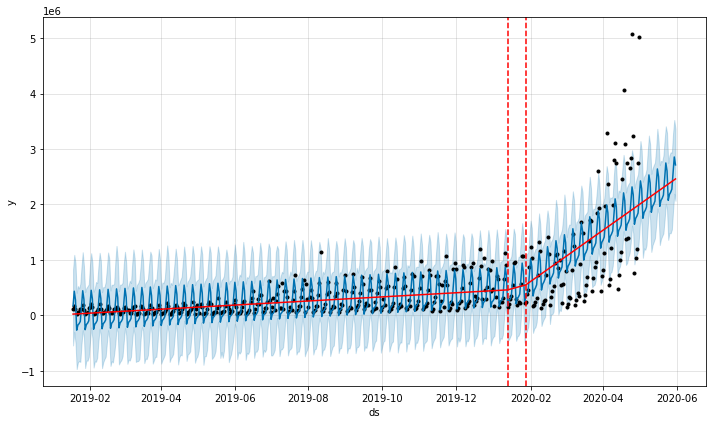

In [52]:
fig = model1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model1, forecast)

In [0]:
br_holidays = holidays.CountryHoliday('BR', years=[2018,2019,2020])

holidays_df = pd.DataFrame()
for date, name in sorted(br_holidays.items()):
  # print(name, date)
  holidays_df = holidays_df.append([[pd.to_datetime(date), name]], ignore_index=True)

In [82]:
holidays_df.rename(columns={0: "ds", 1: "holiday"}, inplace=True, errors="raise")
holidays_df.head()

,ds,holiday
0,2018-01-01,Ano novo
1,2018-02-13,Carnaval
2,2018-02-14,Quarta-feira de cinzas (Início da Quaresma)
3,2018-03-30,Sexta-feira Santa
4,2018-04-01,Páscoa


In [83]:
model2 = Prophet(holidays=holidays_df)
model2.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


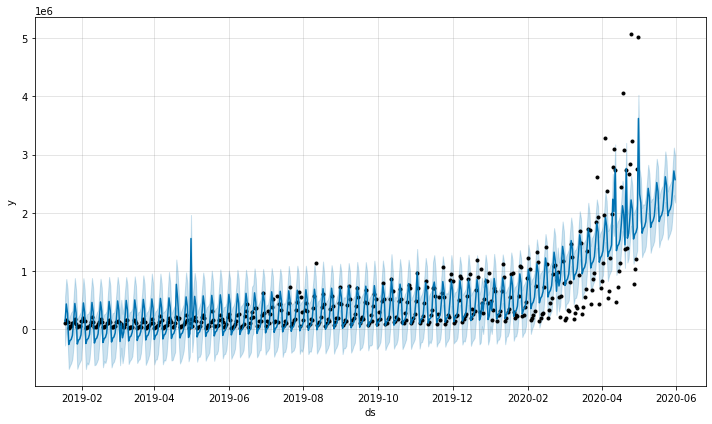

In [85]:
pred_dates2 = model2.make_future_dataframe(periods=30)
forecast2 = model2.predict(pred_dates2)
fig = model2.plot(forecast2)

In [87]:
model_cum = Prophet(holidays=holidays_df, holidays_prior_scale=3, weekly_seasonality=True)
model_cum.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


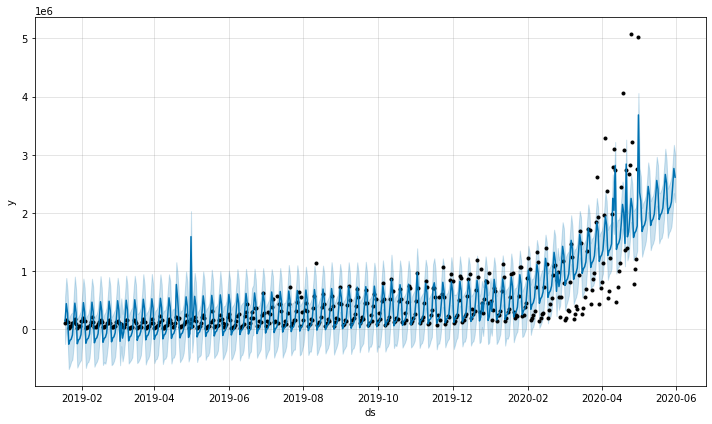

In [88]:
pred_dates = model_cum.make_future_dataframe(30)
forecast = model_cum.predict(pred_dates)
fig = model_cum.plot(forecast)

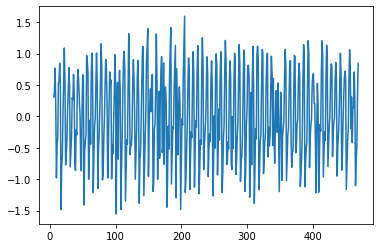

In [93]:
log_data = np.log(train_data['y'])
rolling_mean = log_data.rolling(window=7).mean()
rolling_mean.dropna(inplace=True)

log_data_minus_mean = log_data[6:] - rolling_mean
log_data_minus_mean.plot()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


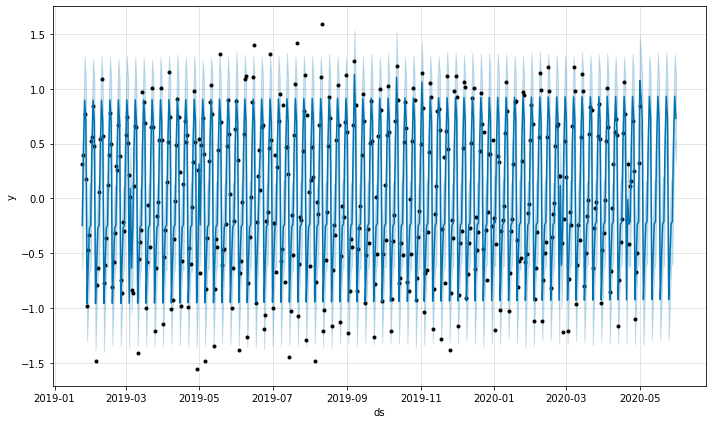

In [109]:
new_data = train_data.copy()
new_data['y'] = log_data_minus_mean
new_data = new_data.dropna(axis=0).reset_index()
new_data.drop(columns='index', inplace=True)

model_cum = Prophet(holidays=holidays_df, holidays_prior_scale=3, weekly_seasonality=True)
model_cum.fit(new_data)

pred_dates = model_cum.make_future_dataframe(30)
forecast = model_cum.predict(pred_dates)
fig = model_cum.plot(forecast)

In [125]:
preds = forecast[['ds', 'yhat']]
pred_vals = preds['yhat']
pred_vals.index = preds['ds'].values
pred_vals

2019-01-24   -0.247827
2019-01-25    0.463017
2019-01-26    0.895845
2019-01-27    0.692757
2019-01-28   -0.959058
                ...   
2020-05-27   -0.232057
2020-05-28   -0.210689
2020-05-29    0.500155
2020-05-30    0.932983
2020-05-31    0.729895
Name: yhat, Length: 494, dtype: float64

In [126]:
pred_vals.iloc[0] = pred_vals.iloc[0] + rolling_mean.iloc[-1]
# pred_vals
pred_vals = pred_vals.cumsum()
pred_vals

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2019-01-24    14.335799
2019-01-25    14.798817
2019-01-26    15.694662
2019-01-27    16.387419
2019-01-28    15.428360
                ...    
2020-05-27    26.104359
2020-05-28    25.893670
2020-05-29    26.393825
2020-05-30    27.326808
2020-05-31    28.056703
Name: yhat, Length: 494, dtype: float64

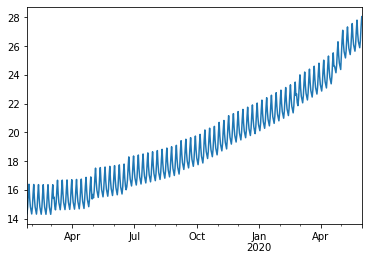

In [127]:
pred_vals.plot()

In [134]:
test_val = np.exp(test_data['y'].values)
test_val

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

overflow encountered in exp



array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf])

0     4.226957e+06
1     2.848925e+06
2     6.725879e+05
3     1.019501e+06
4     1.209558e+06
5     1.191129e+06
6     3.102164e+06
7     5.259688e+06
8     4.609474e+06
9     7.633803e+05
10    1.084651e+06
11    1.322403e+06
12    1.408149e+06
13    3.248028e+06
14    6.064646e+06
15    4.518575e+06
16    7.575857e+05
17    1.196450e+06
18    1.685506e+06
19    2.398436e+06
20    4.873448e+06
21    6.062131e+06
22    3.635290e+06
23    9.956966e+05
24    1.080353e+06
25    1.431521e+06
26    1.695795e+06
27    4.405452e+06
28    6.946844e+06
29    5.262090e+06
Name: y, dtype: float64